In [1]:
!pip install Transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.8 MB/s eta 0:00:00


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, BertTokenizer


In [18]:
import pandas as pd

# Read the text file
with open('/content/questions.txt', 'r') as file:
    lines = file.readlines()

# Prepare the data for classification
questions = []
labels = []
current_label = 0

for line in lines:
    line = line.strip()
    if line == '---':
        current_label += 1
    else:
        questions.append(line)
        labels.append(current_label)

# Create a dataframe for classification
data = pd.DataFrame({'Question': questions, 'Label': labels})


In [67]:
import pandas as pd

# Read the text file
with open('/content/test2.txt', 'r') as file:
    lines = file.readlines()

# Prepare the data for classification
test_questions = []
test_labels = []
current_label = 0

for line in lines:
    line = line.strip()
    if line == '---':
        current_label += 1
    else:
        test_questions.append(line)
        test_labels.append(current_label)

# Create a dataframe for classification
test_data = pd.DataFrame({'Question': test_questions, 'Label': test_labels})

In [4]:
import torch

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [255]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
train_texts = list(data['Question'].astype(str))  # Convert to list of strings

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(train_texts, truncation=True, max_length=20, pad_to_max_length = True, add_special_tokens = True, return_attention_mask = True)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                                               torch.tensor(train_encodings['attention_mask']).to(device),
                                               torch.tensor(data["Label"].values).to(device))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [153]:

test_texts = list(test_data['Question'].astype(str))  # Convert to list of strings

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

test_encodings = tokenizer(test_texts, truncation=True, max_length=40, pad_to_max_length = True, add_special_tokens = True, return_attention_mask = True)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']).to(device),
                                               torch.tensor(test_encodings['attention_mask']).to(device),
                                               torch.tensor(test_data["Label"].values).to(device))

In [247]:
from torch.utils.data.sampler import BatchSampler
class BalancedBatchSampler(BatchSampler):
    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size <= len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size


In [256]:
import numpy as np
batch_sampler = BalancedBatchSampler(train_dataset, n_classes=20, n_samples=11)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=batch_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset)


In [249]:
from transformers import BertTokenizer, BertForSequenceClassification

In [254]:
#Training the model

from transformers import BertForSequenceClassification, AdamW, BertConfig


import torch.nn as nn
from transformers import BertModel

class MetricLearningModel(nn.Module):
    def __init__(self, bert_model):
        super(MetricLearningModel, self).__init__()
        self.bert = bert_model
        self.layer = nn.Linear(768, 256) # Add a 256-dimensional layer

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.layer(pooled_output)
        return output

# Load pre-trained BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Create instance of MetricLearningModel
model = MetricLearningModel(bert_model)

# Tell pytorch to run this model on the GPU.
# if gpu_available == True:
model.to(device)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

In [11]:
!pip install pytorch_metric_learning
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 5.4 MB/s eta 0:00:00


In [261]:
from tqdm import tqdm

# Define the loss function
loss_fn = losses.AngularLoss()

# Number of training epochs (authors recommend between 2 and 4)
epochs = 100

# Loop over the entire dataset multiple times
for epoch in range(epochs):

    # Training
    total_loss = 0.0
    model.train() # Set the model to training mode

    for batch in tqdm(train_loader, desc="Training"):
        # Load batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from the dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Clear previously calculated gradients
        optimizer.zero_grad()

        # Forward pass to get model outputs
        embeddings = torch.nn.functional.normalize(model(b_input_ids, attention_mask=b_input_mask),dim=-1)
        #indices_tuple = miner(embeddings, b_labels)
        loss = loss_fn(embeddings, b_labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate the average loss over the training data

    print('Epoch: {}, Loss: {}'.format(epoch+1, total_loss/len(train_loader)))



Training: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Epoch: 1, Loss: 2.1748220920562744


Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 2, Loss: 2.182180404663086


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 3, Loss: 2.1665918827056885


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 4, Loss: 2.1530380249023438


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 5, Loss: 2.1519715785980225


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 6, Loss: 2.151850938796997


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 7, Loss: 2.1435225009918213


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 8, Loss: 2.143693685531616


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 9, Loss: 2.135491132736206


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 10, Loss: 2.1332333087921143


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 11, Loss: 2.1178364753723145


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 12, Loss: 2.1119754314422607


Training: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 13, Loss: 2.106123685836792


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 14, Loss: 2.1074764728546143


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 15, Loss: 2.1062119007110596


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 16, Loss: 2.1011500358581543


Training: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 17, Loss: 2.0921573638916016


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 18, Loss: 2.096905469894409


Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 19, Loss: 2.0870893001556396


Training: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 20, Loss: 2.076835870742798


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 21, Loss: 2.07366943359375


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 22, Loss: 2.0758256912231445


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 23, Loss: 2.060096263885498


Training: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 24, Loss: 2.061047315597534


Training: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 25, Loss: 2.0577688217163086


Training: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 26, Loss: 2.0475363731384277


Training: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 27, Loss: 2.044135093688965


Training: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 28, Loss: 2.0416224002838135


Training: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch: 29, Loss: 2.0446081161499023


Training: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch: 30, Loss: 2.035482168197632


Training: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 31, Loss: 2.037210464477539


Training: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


Epoch: 32, Loss: 2.034601926803589


Training: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 33, Loss: 2.022892713546753


Training: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 34, Loss: 2.0228888988494873


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 35, Loss: 2.0197527408599854


Training: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 36, Loss: 2.0163044929504395


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 37, Loss: 2.0089874267578125


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 38, Loss: 2.0114519596099854


Training: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 39, Loss: 2.0134103298187256


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 40, Loss: 2.0017001628875732


Training: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 41, Loss: 2.002791166305542


Training: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 42, Loss: 1.9985861778259277


Training: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 43, Loss: 1.9945403337478638


Training: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 44, Loss: 1.991611123085022


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 45, Loss: 1.9919729232788086


Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 46, Loss: 1.984835147857666


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 47, Loss: 1.9870983362197876


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 48, Loss: 1.9834973812103271


Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 49, Loss: 1.9756238460540771


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 50, Loss: 1.9702266454696655


Training: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 51, Loss: 1.9798117876052856


Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 52, Loss: 1.9733092784881592


Training: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 53, Loss: 1.976265788078308


Training: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 54, Loss: 1.9679752588272095


Training: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch: 55, Loss: 1.96329927444458


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 56, Loss: 1.961181402206421


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 57, Loss: 1.9595481157302856


Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 58, Loss: 1.9631165266036987


Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 59, Loss: 1.9558931589126587


Training: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Epoch: 60, Loss: 1.9492864608764648


Training: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 61, Loss: 1.954565167427063


Training: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Epoch: 62, Loss: 1.9479091167449951


Training: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Epoch: 63, Loss: 1.951546549797058


Training: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Epoch: 64, Loss: 1.949209451675415


Training: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch: 65, Loss: 1.95219886302948


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 66, Loss: 1.9411487579345703


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 67, Loss: 1.9454554319381714


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 68, Loss: 1.9462779760360718


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 69, Loss: 1.9404505491256714


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 70, Loss: 1.9377224445343018


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 71, Loss: 1.935834527015686


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 72, Loss: 1.9349913597106934


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 73, Loss: 1.940091848373413


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 74, Loss: 1.9326465129852295


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 75, Loss: 1.9350732564926147


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 76, Loss: 1.9305349588394165


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 77, Loss: 1.9265822172164917


Training: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Epoch: 78, Loss: 1.926419973373413


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 79, Loss: 1.9229241609573364


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 80, Loss: 1.9231114387512207


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 81, Loss: 1.9229187965393066


Training: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch: 82, Loss: 1.9213379621505737


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 83, Loss: 1.9171744585037231


Training: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch: 84, Loss: 1.9191412925720215


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 85, Loss: 1.9222456216812134


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 86, Loss: 1.9154289960861206


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 87, Loss: 1.9164825677871704


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 88, Loss: 1.9158270359039307


Training: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch: 89, Loss: 1.916344165802002


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 90, Loss: 1.9118953943252563


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 91, Loss: 1.9111108779907227


Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 92, Loss: 1.9149913787841797


Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 93, Loss: 1.908158779144287


Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch: 94, Loss: 1.9110609292984009


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 95, Loss: 1.9041526317596436


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 96, Loss: 1.9121711254119873


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 97, Loss: 1.9051109552383423


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 98, Loss: 1.9021400213241577


Training: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Epoch: 99, Loss: 1.899928092956543


Training: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

Epoch: 100, Loss: 1.9039775133132935


In [262]:
train_embeddings = []
train_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader, desc="Training"):
        # Load batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from the dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass to get model outputs
        embeddings = torch.nn.functional.normalize(model(b_input_ids, attention_mask=b_input_mask), dim=-1)

        # Save embeddings and labels
        train_embeddings.append(embeddings.cpu().detach().numpy())
        train_labels.append(b_labels.cpu().detach().numpy())

# Concatenate embeddings and labels
train_embeddings = np.concatenate(train_embeddings, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

Training: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


In [263]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_embeddings, train_labels)


KNeighborsClassifier(n_neighbors=10)

In [264]:
# Set the model to evaluation mode
model.eval()

# Generate embeddings for the test set
test_embeddings = []
test_labels = []
with torch.no_grad():
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            embeddings = torch.nn.functional.normalize(model(b_input_ids, attention_mask=b_input_mask), dim=-1)
        test_embeddings.append(embeddings.cpu().numpy())
        test_labels.append(b_labels.cpu().numpy())

test_embeddings = np.concatenate(test_embeddings, axis=0)
test_labels = np.concatenate(test_labels, axis=0)


# Use kNN to predict labels for the test set embeddings
test_pred_labels = knn.predict(test_embeddings)

# Compute the accuracy of kNN predictions on the test set
accuracy = np.sum(test_pred_labels == test_labels) / len(test_labels)
print('kNN accuracy: {}'.format(accuracy))

kNN accuracy: 1.0


In [265]:

# Read the text file
with open('/content/test2.txt', 'r') as file:
    lines = file.readlines()

# Prepare the data for classification
test_questions = []
test_labels = []
current_label = 0

for line in lines:
    line = line.strip()
    if line == '---':
        current_label += 1
    else:
        test_questions.append(line)
        test_labels.append(current_label)

# Create a dataframe for classification
test_data = pd.DataFrame({'Question': test_questions, 'Label': test_labels})

In [266]:

test_texts = list(test_data['Question'].astype(str))  # Convert to list of strings

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

test_encodings = tokenizer(test_texts, truncation=True, max_length=40, pad_to_max_length = True, add_special_tokens = True, return_attention_mask = True)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']).to(device),
                                               torch.tensor(test_encodings['attention_mask']).to(device),
                                               torch.tensor(test_data["Label"].values).to(device))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [267]:

test_loader = torch.utils.data.DataLoader(test_dataset)


In [268]:
model.eval()

# Generate embeddings for the test set
test_embeddings = []
test_labels = []
test_samples = []  # Add a list to store test samples
with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            embeddings = torch.nn.functional.normalize(model(b_input_ids, attention_mask=b_input_mask), dim=-1)
        test_embeddings.append(embeddings.cpu().numpy())
        test_labels.append(b_labels.cpu().numpy())
        test_samples.extend(b_input_ids.cpu().numpy())  # Add the test samples to the list

test_embeddings = np.concatenate(test_embeddings, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Use kNN to predict labels for the test set embeddings
test_pred_labels = knn.predict(test_embeddings)

# Compute the accuracy of kNN predictions on the test set
accuracy = np.sum(test_pred_labels == test_labels) / len(test_labels)
print('kNN accuracy for test data: {}'.format(accuracy))

# Iterate over test samples and compare predicted labels with ground truth labels
for i in range(len(test_labels)):
    if test_pred_labels[i] != test_labels[i]:
        print('Incorrect prediction:')
        print('Predicted label:', test_pred_labels[i])
        print('Ground truth label:', test_labels[i])
        sample_text = tokenizer.decode(test_samples[i], skip_special_tokens=True)
        print('Sample:', sample_text)
        print()

kNN accuracy for test data: 0.96
Incorrect prediction:
Predicted label: 3
Ground truth label: 5
Sample: what is the limit on the number of semestrs for the z degee?

Incorrect prediction:
Predicted label: 3
Ground truth label: 5
Sample: could you provide information about the z degee's maximum semstr count?

Incorrect prediction:
Predicted label: 3
Ground truth label: 7
Sample: can you tell me the min requird essential courses to get a z degre?

Incorrect prediction:
Predicted label: 5
Ground truth label: 7
Sample: hello, how's your mood today? how many courses are considerd essential to complete a z degee?

Incorrect prediction:
Predicted label: 9
Ground truth label: 12
Sample: can you direct me to the place wher i can find bok b?

Incorrect prediction:
Predicted label: 4
Ground truth label: 13
Sample: hi, how's your state of mind? i'm looking for the specific plac wher class cl is held. i'm truly touched by your kindness.

Incorrect prediction:
Predicted label: 9
Ground truth label: 

In [ ]:
test_sentence = "can you give me a list of the professors' names?"

# Preprocess the test sentence
test_encoding = tokenizer.encode_plus(
    test_sentence,
    truncation=True,
    max_length=20,
    padding='max_length',
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Move the test encoding to the GPU (if available)
test_encoding = {key: value.to(device) for key, value in test_encoding.items()}

# Generate embeddings for the test sentence
with torch.no_grad():
    test_embedding = torch.nn.functional.normalize(model(test_encoding['input_ids'], attention_mask=test_encoding['attention_mask']), dim=-1)

# Use kNN to predict the labels for the test sentence embeddings
test_pred_labels = knn.predict(test_embedding.cpu().numpy())

label_test = data[data['Label'] == int(test_pred_labels)]
print(label_test)

                                              Question  Label
198            what is the names of all of professors?     18
199          what are the names of all the professors?     18
200  can you provide me with the names of all the p...     18
201          could you list all the professors' names?     18
202  i would like to know the names of all the prof...     18
203    please tell me the names of all the professors.     18
204  could you share with me the names of all the p...     18
205                    what are the professors' names?     18
206   can you give me a list of the professors' names?     18
207  i'm interested in knowing the names of all the...     18
208  could you enlighten me about the names of all ...     18


In [242]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=4ea8db3d39dba15478ff67e42f25ee0c27267bea9a601c7825adf585e46172a2
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=f51f8b09ceeb311a11ef2681a2adc0fee999e06a89539aebc5c8fe22e3c2f301
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [243]:
x=embeddings[0]
x.min(),x.max(),x.mean(),x.std()

(tensor(-0.1807, device='cuda:0'),
 tensor(0.2193, device='cuda:0'),
 tensor(-0.0009, device='cuda:0'),
 tensor(0.0626, device='cuda:0'))

In [244]:
#Training the model

from transformers import BertForSequenceClassification, AdamW, BertConfig

import torch.nn as nn
from transformers import BertModel

class Model(nn.Module):
    def __init__(self, bert_model):
        super(Model, self).__init__()
        self.bert = bert_model


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        # Remove the layer
        return pooled_output

# Load pre-trained BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Create instance of MetricLearningModel
model2 = Model(bert_model)

model2.to(device)

optimizer = AdamW(model2.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 

In [ ]:
train_embeddings2 = []
train_labels2 = []
model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader, desc="Training"):
        # Load batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from the dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass to get model outputs
        embeddings = torch.nn.functional.normalize(model2(b_input_ids, attention_mask=b_input_mask), dim=-1)

        # Save embeddings and labels
        train_embeddings2.append(embeddings.cpu().detach().numpy())
        train_labels2.append(b_labels.cpu().detach().numpy())

# Concatenate embeddings and labels
train_embeddings2 = np.concatenate(train_embeddings2, axis=0)
train_labels2 = np.concatenate(train_labels2, axis=0)

Training: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


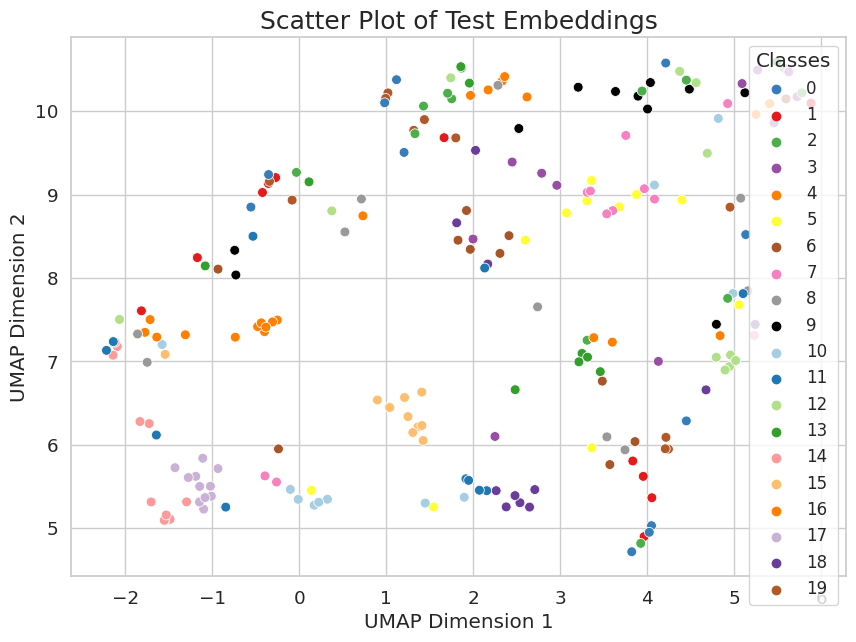

In [ ]:
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataLoader called 'test_loader' that loads your test data

# Step 1: Extract embeddings and labels
embeddings = []
labels = []

embeddings = train_embeddings2
labels = train_labels2

# Step 2: Reduce dimensionality using UMAP
reducer = umap.UMAP()
test_emb = reducer.fit_transform(embeddings)

# Step 3: Set plot style and font scale
sns.set(style='whitegrid', font_scale=1.2)

# Step 4: Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000',
          '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99',
          '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#b15928']

plt.figure(figsize=(10, 7))
sns.scatterplot(x=test_emb[:, 0], y=test_emb[:, 1], hue=labels, s=50, palette=colors)

# Step 5: Add axis labels and title
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Scatter Plot of Test Embeddings', fontsize=18)

# Step 6: Add legend
plt.legend(title='Classes', loc='best', fontsize=12)

# Step 7: Add grid lines
plt.grid(True)

# Step 8: Show the plot
plt.show()

In [270]:
train_embeddings = []
train_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader, desc="Training"):
        # Load batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from the dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass to get model outputs
        embeddings = torch.nn.functional.normalize(model(b_input_ids, attention_mask=b_input_mask), dim=-1)

        # Save embeddings and labels
        train_embeddings.append(embeddings.cpu().detach().numpy())
        train_labels.append(b_labels.cpu().detach().numpy())

# Concatenate embeddings and labels
train_embeddings = np.concatenate(train_embeddings, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

Training: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


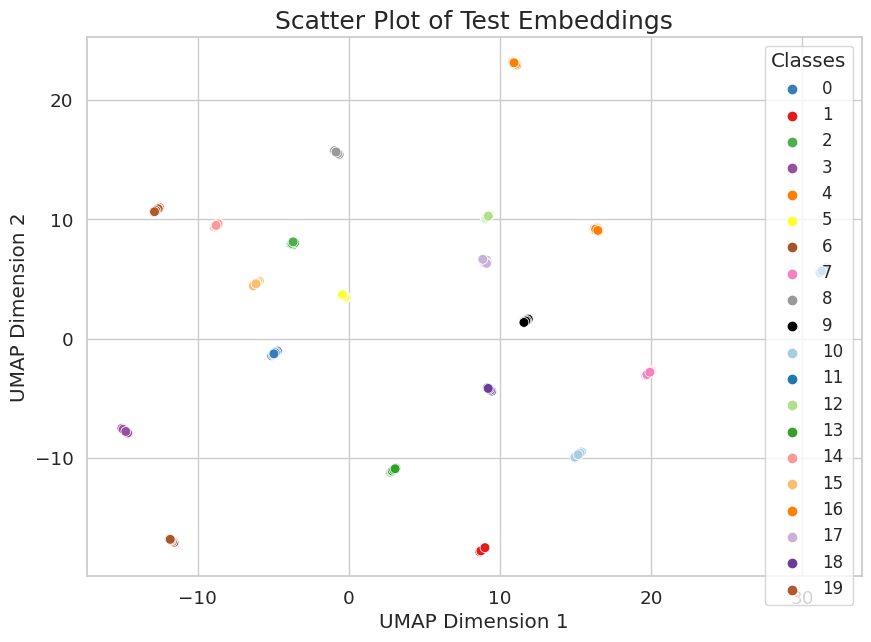

In [277]:
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataLoader called 'test_loader' that loads your test data

# Step 1: Extract embeddings and labels
embeddings = []
labels = []

embeddings = train_embeddings
labels = train_labels

# Step 2: Reduce dimensionality using UMAP
reducer = umap.UMAP()
test_emb = reducer.fit_transform(embeddings)

# Step 3: Set plot style and font scale
sns.set(style='whitegrid', font_scale=1.2)

# Step 4: Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000',
          '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99',
          '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#b15928']

plt.figure(figsize=(10, 7))
sns.scatterplot(x=test_emb[:, 0], y=test_emb[:, 1], hue=labels, s=50, palette=colors)

# Step 5: Add axis labels and title
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Scatter Plot of Test Embeddings', fontsize=18)

# Step 6: Add legend
plt.legend(title='Classes', loc='best', fontsize=12)

# Step 7: Add grid lines
plt.grid(True)

# Step 8: Show the plot
plt.show()

In [278]:
test_embeddings = []
test_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Training"):
        # Load batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from the dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass to get model outputs
        embeddings = torch.nn.functional.normalize(model(b_input_ids, attention_mask=b_input_mask), dim=-1)

        # Save embeddings and labels
        test_embeddings.append(embeddings.cpu().detach().numpy())
        test_labels.append(b_labels.cpu().detach().numpy())

# Concatenate embeddings and labels
test_embeddings = np.concatenate(test_embeddings, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

Training: 100%|██████████| 200/200 [00:03<00:00, 63.54it/s]


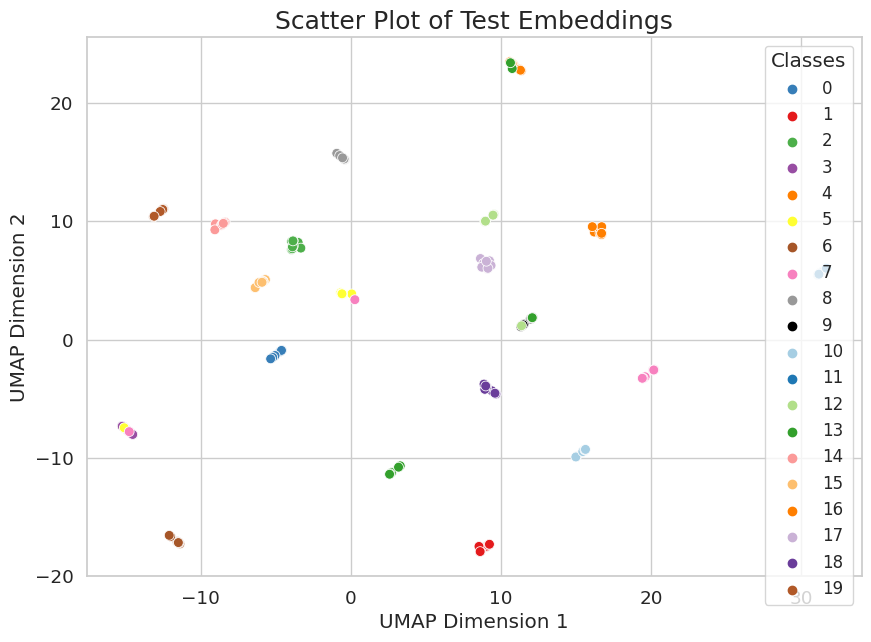

In [279]:
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataLoader called 'test_loader' that loads your test data

# Step 1: Extract embeddings and labels
embeddings = []
labels = []

embeddings = test_embeddings
labels = test_labels

# Step 2: Reduce dimensionality using UMAP

test_emb = reducer.transform(embeddings)

# Step 3: Set plot style and font scale
sns.set(style='whitegrid', font_scale=1.2)

# Step 4: Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000',
          '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99',
          '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#b15928']

plt.figure(figsize=(10, 7))
sns.scatterplot(x=test_emb[:, 0], y=test_emb[:, 1], hue=labels, s=50, palette=colors)

# Step 5: Add axis labels and title
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Scatter Plot of Test Embeddings', fontsize=18)

# Step 6: Add legend
plt.legend(title='Classes', loc='best', fontsize=12)

# Step 7: Add grid lines
plt.grid(True)

# Step 8: Show the plot
plt.show()

In [ ]:
!pip install owlready2
!pip install rdflib
from owlready2 import *
import rdflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 51.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for owlready2: filename=Owlready2-0.43-cp310-cp310-linux_x86_64.whl size=24154510 sha256=b29fc72c09402c89cbf03e267bfd61abbb71e36f1ffb406644bc87e3b260ac73
  Stored in directory: /root/.cache/pip/wheels/bc/9b/82/c07844dfbaa52dbf3352b18b0a27c348ee854df8b752990c53
Successfully built owlready2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd


sentence = "how many semesters  i ve to ps for masters?"


replacements = {
    "shamsfard": "x",
    "salimibadr": "x",
    "ghavamizadeh": "x",
    "abdoos": "x",
    "computer engineering": "y",
    "industrial engineering": "y",
    "ai": "c",
    "nlp": "c",
    "russel": "b",
    "101": "cl",
    "masters": "z",
    "bachelors": "z",
    "phd": "z",
    "1400": "t"
}


replaced_words = {
    "x": None,
    "y": None,
    "c": None,
    "b": None,
    "cl": None,
    "z": None,
    "t": None
}


for word, replacement in replacements.items():

    if word.lower() in sentence.lower():
        replaced_words[replacement] = word
        sentence = sentence.replace(word, replacement)


df = pd.DataFrame(replaced_words, index=[0])

# Print the modified sentence
print("Modified Sentence:", sentence)
print()

# Print the resulting dataframe
print("Dataframe:")
print(df)



Modified Sentence: how many semesters  i ve to ps for z?

Dataframe:
      x     y     c     b    cl        z     t
0  None  None  None  None  None  masters  None


In [ ]:
test_sentence = sentence

# Preprocess the test sentence
test_encoding = tokenizer.encode_plus(
    test_sentence,
    truncation=True,
    max_length=20,
    padding='max_length',
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Move the test encoding to the GPU (if available)
test_encoding = {key: value.to(device) for key, value in test_encoding.items()}

# Generate embeddings for the test sentence
with torch.no_grad():
    test_embedding = torch.nn.functional.normalize(model(test_encoding['input_ids'], attention_mask=test_encoding['attention_mask']), dim=-1)

# Use kNN to predict the labels for the test sentence embeddings
test_pred_labels = knn.predict(test_embedding.cpu().numpy())

label_test = data[data['Label'] == int(test_pred_labels)]
print(label_test)

                                             Question  Label
55  what is the maximum number of semesters in the...      5
56  what is the highest allowed number of semester...      5
57  can you tell me the maximum semester limit for...      5
58  how many semesters can one take to complete th...      5
59  what is the upper limit of semesters for the z...      5
60  is there a cap on the number of semesters for ...      5
61  can you provide information on the maximum dur...      5
62  what is the maximum semester count for complet...      5
63  how long can one extend their studies in terms...      5
64  what is the prescribed semester range for the ...      5
65  can you inform me about the allowed length in ...      5


In [ ]:
!pip install rdflib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
from rdflib import Graph

graph = Graph()

graph.parse("/content/uni_rdf(1).rdf")

your_namespace = "http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#"


test_pred_labels = int(test_pred_labels)

if test_pred_labels == 0:
    if df['x'][0] == 'shamsfard':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:دکتر_شمس_فرد your_namespace:شماره_تلفن ?value .
        }
      """
    results = graph.query(query)

    # Print the results
    for row in results:
        value = row["value"]
        print(value)




elif test_pred_labels == 1:
    if df['x'][0] == 'shamsfard':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?destination
        WHERE {
          your_namespace:دکتر_شمس_فرد your_namespace:تدریس_میکند ?destination .
        }
      """
    results = graph.query(query)

    for row in results:
        destination = row.destination.toPython()
        label = destination.split("#")[-1]
        print(label)


if test_pred_labels == 2:
    if df['x'][0] == 'shamsfard':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:دکتر_شمس_فرد your_namespace:آخرین_مدرک_اخذ_شده ?value .
        }
      """
    results = graph.query(query)

    # Print the results
    for row in results:
        value = row["value"]
        print(value)

if test_pred_labels == 3:
    if df['z'][0] == 'masters':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:قانون_فارغ_التحصیلی your_namespace:تعداد_واحد_مورد_نیاز_برای_فارغ_التحصیلی ?value .
        }
      """
        results = graph.query(query)

    # Print the results
        for row in results:
            value = row["value"]
            print(value)


    elif df['z'][0] == 'bachelors':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:دکتر_شمس_فرد your_namespace:آخرین_مدرک_اخذ_شده ?value .
        }
      """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)




elif test_pred_labels == 4:
    if df['y'][0] == 'computer engineering':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:سایت_دانشکده your_namespace:آدرس_تارنما ?value .
        }
      """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)



elif test_pred_labels == 5:
    if df['z'][0] == 'masters':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:قانون_سنوات_ارشد your_namespace:تعداد_ترم ?value .
        }
      """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)



elif test_pred_labels == 6:
    if df['z'][0] == 'masters':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:قانون_مشروطی_در_ارشد your_namespace:معدل_مشروطی ?value .
        }
      """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)



elif test_pred_labels == 7:
    if df['z'][0] == 'masters':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:قانون_فارغ_التحصیلی your_namespace:حداقل_تعداد_دروس_اصلی ?value .
        }
      """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)





elif test_pred_labels == 8:
    if df['y'][0] == 'computer engineering':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:دانشکده_کامپیوتر_بهشتی your_namespace:رمز_وای_فای ?value .
        }
      """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)


elif test_pred_labels == 9:
    if df['c'][0] == 'ai':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?destination
        WHERE {
          your_namespace:درس_هوش_مصنوعی_در_ترم_دوم_سال_1402 your_namespace:برگزار_میشود_در ?destination .
        }
      """
        results = graph.query(query)

        for row in results:
            destination = row.destination.toPython()
            label = destination.split("#")[-1]
            print(label)


elif test_pred_labels == 10:
    if df['z'][0] == 'masters' and df['t'][0] == '1400':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:قانون_مرتبط_با_پایان_نامه_ارشد your_namespace:مهلت_دفاع_پایان_نامه ?value .
        }
      """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)



elif test_pred_labels == 11:

    query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
       PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:معاونت_آموزشی_دانشکده_کامپیوتر_بهشتی your_namespace:منصوب_میشود_به ?value .
        }
      """
    results = graph.query(query)

    # Print the results
    for row in results:
        value = row["value"]
        print(value)



elif test_pred_labels == 12:
    if df['b'][0] == 'russel':
        query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
       PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:کتاب__راسل your_namespace:موجود_است_در ?value .
        }
      """
        results = graph.query(query)

    # Print the results
        for row in results:
            value = row["value"]
            print(value)

elif test_pred_labels == 13:
    if df['cl'][0] == '104':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:کلاس_104_دانشکده_کامپیوتر your_namespace:آدرس_مکان ?value .
        }
      """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)



elif test_pred_labels == 14:
    query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

SELECT ?value
WHERE {
  your_namespace:قانون_خوابگاه_برای_پردیس your_namespace:تعلق_میگیرد ?value .
}
    """
    results = graph.query(query)

    # Print the results
    for row in results:
        value = row["value"]
        if (value.value==False):
            print("تعلق نمیگیرد")
        if (value.value==True):
            print("تعلق میگیرد")


elif test_pred_labels == 15:

    query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

SELECT ?value
WHERE {
  your_namespace:کتابخانه_مرکزی_دانشکده_بهشتی your_namespace:آدرس_مکان ?value .
}
    """
    results = graph.query(query)

    # Print the results
    for row in results:
        value = row["value"]
        print(value)


elif test_pred_labels == 16:

    query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

SELECT ?value
WHERE {
  your_namespace:قانون_آموزش_محور_برای_ارشد your_namespace:تعریف_آموزش_محور ?value .
}
    """
    results = graph.query(query)

    # Print the results
    for row in results:
        value = row["value"]
        print(value)


elif test_pred_labels == 17:
    if df['y'][0] == 'computer engineering':
        query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

SELECT ?value
WHERE {
  your_namespace:دانشکده_کامپیوتر_بهشتی your_namespace:گروه_آموزشی_دانشکده ?value .
}
    """
        results = graph.query(query)

        # Print the results
        for row in results:
            value = row["value"]
            print(value)


elif test_pred_labels == 18:

    query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

SELECT ?instance
WHERE {
  ?subclass rdfs:subClassOf your_namespace:استاد .
  ?instance rdf:type ?subclass .
}
    """
    results = graph.query(query)

    for row in results:
        instance_uri = row['instance']
        instance_local_name = instance_uri.split('#')[-1]
        print(instance_local_name)


if test_pred_labels == 19:
    if df['x'][0] == 'shamsfard':
        query = """
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX your_namespace: <http://www.semanticweb.org/sepideh/ontologies/2023/5/university-ontology#>

        SELECT ?value
        WHERE {
        your_namespace:دفتر_دکتر_شمس_فرد your_namespace:ساعت_حضور ?value .
        }
      """
        results = graph.query(query)

    # Print the results
        for row in results:
            value = row["value"]
            print(value)



5


In [ ]:
df['y'][0] =